In [1]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
from src.caseDataset import CaseDataset

## Check GPU Availability

In [4]:
# Check GPU status:
print('PyTorch version:',t.__version__)
useGPU = t.cuda.is_available()
if(useGPU):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    dev = t.cuda.current_device()
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.8.2
Device  0 : NVIDIA GeForce GTX 1050
Current: Device  0


## Load Data

In [5]:
# load data
txtSubname = "zeroOne"
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
A, B, C, D = coef[0], coef[1], coef[2], coef[3]
totalData

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,1.0,0.06,-1.0,0.0,35.0,0.0,33.697378,9.019101,37.7,2.7,25.922577,8.369963,43.4,2.7,41.524108,3.033909
1,0.0,0.78,1.0,1.0,65.0,195.0,70.238247,195.851224,174.2,209.2,177.053114,200.668418,100.1,209.2,100.264274,202.046721
2,1.0,0.26,-1.0,0.0,35.0,0.0,35.580748,-11.171354,46.7,11.7,50.302859,9.063450,71.4,11.7,70.472655,7.401377
3,0.0,1.00,1.0,0.0,0.0,35.0,5.238357,32.858948,45.0,80.0,42.859703,84.600850,45.0,175.0,43.660540,170.367236
4,0.0,0.88,1.0,1.0,65.0,195.0,59.672723,192.887494,188.2,223.2,179.875829,218.395098,104.6,223.2,112.765823,220.432240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.94,1.0,0.0,0.0,35.0,4.645466,33.391103,42.3,77.3,46.716795,80.209133,42.3,166.6,36.689255,161.140605
996,1.0,0.44,-1.0,0.0,35.0,0.0,41.037805,0.645514,54.8,19.8,47.855456,14.220954,96.6,19.8,99.058721,28.949107
997,0.0,0.66,1.0,1.0,65.0,195.0,59.580476,205.414999,157.4,192.4,157.073168,184.435104,94.7,192.4,91.017968,200.343266
998,1.0,0.48,-1.0,1.0,195.0,65.0,192.411495,57.994711,167.2,132.2,167.974533,127.437078,167.2,86.6,158.952443,89.989629


In [6]:
totalData.describe()

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
count,1000.00000,1000.000000,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000
mean,0.50000,0.510000,0.0000,0.50000,73.750000,73.750000,73.514979,73.740348,97.175000,97.175000,96.921461,97.211245,85.6021,108.747900,85.523519,108.511299
std,0.50025,0.288762,1.0005,0.50025,73.723284,73.723284,73.833029,73.952801,60.332229,72.237069,60.607736,72.043071,41.0202,73.840558,41.207523,73.993564
min,0.00000,0.020000,-1.0000,0.00000,0.000000,0.000000,-15.789670,-14.726891,2.700000,0.900000,8.881430,-6.932425,2.7000,0.900000,-1.827053,-4.857703
25%,0.00000,0.260000,-1.0000,0.00000,26.250000,26.250000,20.158536,16.759060,40.475000,41.750000,40.463493,38.436597,43.2000,44.600000,44.104181,41.337715
50%,0.50000,0.510000,0.0000,0.50000,50.000000,50.000000,52.584723,46.894390,83.700000,76.400000,78.947980,78.828868,92.4500,90.650000,92.324096,95.396943
75%,1.00000,0.760000,1.0000,1.00000,97.500000,97.500000,102.364524,103.209562,153.550000,139.900000,154.127323,147.485061,108.4000,172.800000,109.156440,172.354165
max,1.00000,1.000000,1.0000,1.00000,195.000000,195.000000,208.491267,210.470866,217.600000,240.000000,213.717689,246.782913,217.6000,240.000000,221.806115,246.510211


In [7]:
trainData, testData = totalData, totalData#train_test_split(totalData, test_size=0.2)

caseType = 3
trainCaseData = CaseDataset(trainData, caseType=caseType)
testCaseData = CaseDataset(testData, caseType=caseType)
print("TrainCase Treat Rate: {}".format(np.mean(trainCaseData.T == 1)))
print("TestCase Treat Rate: {}".format(np.mean(testCaseData.T == 1)))

TrainCase Treat Rate: 0.5
TestCase Treat Rate: 0.5


In [8]:
iteration = 1
trainDataLoader = DataLoader(trainCaseData, batch_size=int(len(trainCaseData)/iteration), shuffle=True)
print("Batched Training Shape of")
for i, (batchFeature, batchTarget) in enumerate(trainDataLoader):
    print("No. {} | Feature: {} | Target: {}".format(i, batchFeature.shape, batchTarget.shape))
print("\n")
testDataLoader = DataLoader(testCaseData, batch_size=int(len(testCaseData)/iteration), shuffle=False)
testFeature, testTarget = next(iter(testDataLoader))
print("Test Shape of \nFeature: {} | Target: {}".format(testFeature.shape, testTarget.shape))

Batched Training Shape of
No. 0 | Feature: torch.Size([1000, 3]) | Target: torch.Size([1000])


Test Shape of 
Feature: torch.Size([1000, 3]) | Target: torch.Size([1000])


---

## Model Build Up

In [9]:
from src.neuralNetwork import *
from os import path

In [10]:
doRetrain = True
PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
if path.isfile(PATH):
    model = NeuralNetwork()
    model.load_state_dict(t.load(PATH))
    print('load model from '+PATH)
    doTrainModel = False
    if doRetrain:
        doTrainModel = True
else:
    print('create new model')
    model = NeuralNetwork()
    doTrainModel = True

create new model


In [11]:
loss_fn = t.nn.MSELoss()
learningRate = 1e-5
optimizer = t.optim.RMSprop(model.parameters())#, lr=learningRate)


model = model.to(dev)
loss_fn = loss_fn.to(dev)
if useGPU:
    print('---------- Turn Model/LossFunction into GPU ----------')
else:
    print('---------- Turn Model/LossFunction into CPU ----------')
print(model)

---------- Turn Model/LossFunction into GPU ----------
NeuralNetwork(
  (linearLayer): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [12]:
#del model

In [13]:
numEpochs = 1000

if doTrainModel:
    for epochIdx in range(numEpochs+1):
        loss = trainLoop(dataLoader=trainDataLoader, model=model, optimizer=optimizer, lossFn=loss_fn, dev=dev)
        if epochIdx % 250 == 0:
            print('-' * 20 + str(epochIdx) + '-' * 20)    
            print('Loss: {}'.format(loss))


print('=' * 10 + 'COMPLETE' + '=' * 10)

--------------------0--------------------
Loss: 8989.83984375
--------------------250--------------------
Loss: 136.50340270996094
--------------------500--------------------
Loss: 70.57695770263672
--------------------750--------------------
Loss: 52.13667297363281
--------------------1000--------------------
Loss: 38.18447494506836
==========COMPLETE==========


In [14]:
yTrainPred = evaluate(model, trainCaseData.feature, dev=dev)
yTrainPredCF = evaluate(model, trainCaseData.featureCF, dev=dev)

In [15]:
doDraw = True

In [16]:
import matplotlib.pyplot as plt 
import numpy as np 
def drawOutcomesVersusRandom(trainCaseData, yPred, yType, coefficients, title, yPredCF=None):
    uniqueOutcome, countUnique = np.unique(trainCaseData.data['yo'+yType], return_counts=True)
    A, B, C, D = coefficients[0], coefficients[1], coefficients[2], coefficients[3]
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(len(uniqueOutcome)):
        # ========== Treated
        if np.sum([(trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('green')
                pc.set_edgecolor('green')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('green')
                vp.set_facecolor('green')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='green', fontsize=25, ha='center')

        # ========== Untreated
        elif np.sum([(trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('red')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('red')
                vp.set_facecolor('red')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='red', fontsize=25, ha='center')

    size = 70
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType], color='black', zorder=3)
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType+'CF'], color='black', zorder=3, marker='x')
    if title == "Total":
        plt.scatter(trainCaseData.data['yo'+yType], yPred, color='blue', zorder=3, alpha=0.5, label='Total Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType], yPredCF, \
                        color='red', zorder=3, alpha=0.5, label='Total CF Prediction', s=size*0.5, marker='x')
        
    elif title == "Old":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPred[trainCaseData.Age == 1], color='blue', \
                    zorder=3, alpha=0.5, label='Old Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPredCF[trainCaseData.Age == 1], \
                        color='red', zorder=3, alpha=0.5, label='Old CF Prediction', s=size*0.5, marker='x')

    elif title == "Young":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPred[trainCaseData.Age == -1], \
                    color='blue', zorder=3, alpha=0.5, label='Young Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPredCF[trainCaseData.Age == -1], \
                        color='red', zorder=3, alpha=0.5, label='Young CF Prediction', s=size*0.5, marker='x')
            
    plt.xlabel('Without Noise', fontsize=30)
    plt.xticks(fontsize=30)
    plt.ylabel('With Noise', fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.xlim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.legend(fontsize=20, loc='upper right')
    if title:
        plt.title("Prediction | Case {} | {}".format(yType, title), fontsize=30)
    plt.show()


In [17]:
def drawOutcomes(caseData, yType, titleAppend):
    yClass = 'y{}'.format(yType)
    yClassCF = 'y{}CF'.format(yType)
    data = caseData.data
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    # treat & male
    condition = np.logical_and(data['T']==1, data['Sex']==1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='blue')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='blue', marker='x')
    # treat & female
    condition = np.logical_and(data['T']==1, data['Sex']==-1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='red')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='red', marker='x')
    # untreat & male
    condition = np.logical_and(data['T']==-1, data['Sex']==1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='blue', marker='x')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='blue')
    # untreat & female
    condition = np.logical_and(data['T']==-1, data['Sex']==-1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='red', marker='x')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='red')
    
    xAmplitude = (np.max(data['Age']) - np.min(data['Age']))/2
    axs[0].set_xlim(np.min(data['Age'])-(xAmplitude)*0.1, np.max(data['Age'])+(xAmplitude)*0.1)
    axs[1].set_xlim(np.min(data['Age'])-(xAmplitude)*0.1, np.max(data['Age'])+(xAmplitude)*0.1)
    
    yAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    axs[1].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    
    axs[0].set_xlabel('Age', fontsize=20)
    axs[0].tick_params(axis='both', labelsize=20)
    axs[0].set_ylabel('Outcome', fontsize=20)
    axs[1].set_xlabel('Age', fontsize=20)
    axs[1].tick_params(axis='both', labelsize=20)
    axs[1].set_ylabel('Counterfactual Outcome', fontsize=20)
    fig.suptitle('Case {} | {}'.format(yType, titleAppend), fontsize=40)
    plt.show()

In [18]:
def drawTruthNoise(caseData, prediction, predictionCF, yType, titleAppend):
    yClass = 'y{}'.format(yType)
    yoClass = 'yo{}'.format(yType)
    yClassCF = 'y{}CF'.format(yType)
    yoClassCF = 'yo{}CF'.format(yType)

    data = caseData.data
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].plot([np.min(data[yClass]), np.max(data[yClass])], [np.min(data[yClass]), np.max(data[yClass])], color='grey')
    axs[1].plot([np.min(data[yClass]), np.max(data[yClass])], [np.min(data[yClass]), np.max(data[yClass])], color='grey')
    axs[0].scatter(data[yoClass], data[yoClass], zorder=3, c='black')
    axs[1].scatter(data[yoClassCF], data[yoClassCF], zorder=3, c='black')
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    # treat & male
    condition = np.logical_and(data['T']==np.max(data['T']), data['Sex']==np.max(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='blue')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='blue', marker='x')
    # treat & female
    condition = np.logical_and(data['T']==np.max(data['T']), data['Sex']==np.min(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='red')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='red', marker='x')
    # untreat & male
    condition = np.logical_and(data['T']==np.min(data['T']), data['Sex']==np.max(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='blue', marker='x')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='blue')
    # untreat & female
    condition = np.logical_and(data['T']==np.min(data['T']), data['Sex']==np.min(data['Sex']))
    axs[0].scatter(data[yClass][condition], prediction[condition], color='red', marker='x')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='red')
    
    xAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_xlim(np.min(data[yClass])-(xAmplitude)*0.1, np.max(data[yClass])+(xAmplitude)*0.1)
    axs[1].set_xlim(np.min(data[yClassCF])-(xAmplitude)*0.1, np.max(data[yClassCF])+(xAmplitude)*0.1)
    
    yAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    axs[1].set_ylim(np.min(data[yClassCF])-(yAmplitude)*0.1, np.max(data[yClassCF])+(yAmplitude)*0.1)
    
    axs[0].set_xlabel('Truth+Noise', fontsize=20)
    axs[0].tick_params(axis='both', labelsize=20)
    axs[0].set_ylabel('Factual Prediction', fontsize=20)
    axs[1].set_xlabel('Truth+Noise', fontsize=20)
    axs[1].tick_params(axis='both', labelsize=20)
    axs[1].set_ylabel('Counterfactual Prediction', fontsize=20)
    fig.suptitle('Case {}'.format(yType), fontsize=40)
    plt.show()

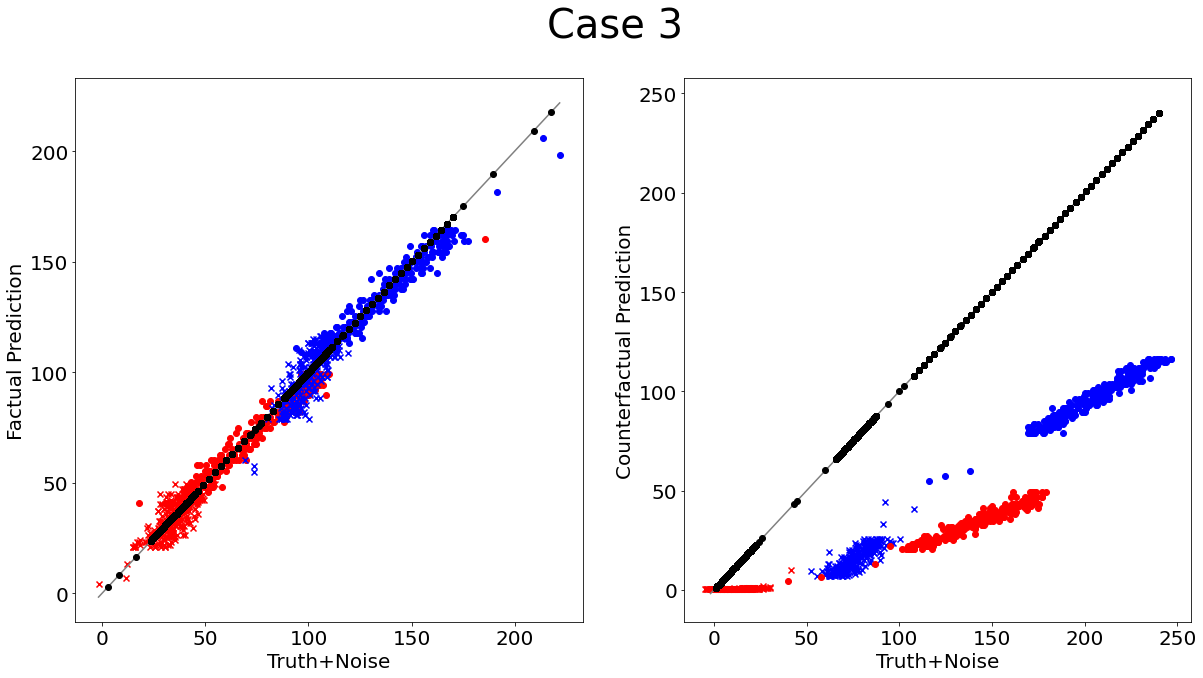

In [19]:
if doDraw:
    yType = str(caseType)
    drawTruthNoise(trainCaseData, yTrainPred, yTrainPredCF, yType, titleAppend=None)

In [20]:
print("{:05f}/{:05f}".format(RMSE(yTrainPred[:, 0], trainCaseData.data['y{}'.format(caseType)]), RMSE(trainCaseData.data['yo{}'.format(caseType)], trainCaseData.data['y{}'.format(caseType)])))
print("{:05f}/{:05f}".format(RMSE(yTrainPredCF[:, 0], trainCaseData.data['y{}CF'.format(caseType)]), RMSE(trainCaseData.data['yo{}CF'.format(caseType)], trainCaseData.data['y{}CF'.format(caseType)])))

6.178640/4.918277
82.600905/4.936745


In [21]:
#del model

In [22]:
saveModel=True
if saveModel:
    PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
    t.save(model.state_dict(), PATH)
    the_model = NeuralNetwork()
    the_model.load_state_dict(t.load(PATH))